<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclassification/applications/classification/grammatically_correct_sentence/CoLA%20with%20BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [ ]:
!pip install transformers
!pip install wget

### CoLA (Corpus of Linguistic Acceptability) Dataset

In [ ]:
import os
import wget

print('Downloading dataset')
# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [ ]:
if not os.path.exists('./cola_public'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
replace cola_public/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: cola_public/README      
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [ ]:
!ls

cola_public  cola_public_1.1.zip  sample_data


### Imports

In [61]:
import time

import pandas as pd
import numpy as np

import torch
import torch.nn as nn

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import model_selection
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [19]:
train_file = "cola_public/raw/in_domain_train.tsv"
test_file = "cola_public/raw/in_domain_dev.tsv"

In [20]:
df_train = pd.read_csv(train_file, sep='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_valid = pd.read_csv(test_file, sep='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

### Data Analysis

In [21]:
df_train.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [22]:
df_train = df_train.drop(columns=['sentence_source', 'label_notes'])
df_train.head()

,label,sentence
0,1,"Our friends won't buy this analysis, let alone..."
1,1,One more pseudo generalization and I'm giving up.
2,1,One more pseudo generalization or I'm giving up.
3,1,"The more we study verbs, the crazier they get."
4,1,Day by day the facts are getting murkier.


In [23]:
df_valid = df_valid.drop(columns=['sentence_source', 'label_notes'])

In [24]:
df_train.shape, df_valid.shape

((8551, 2), (527, 2))

In [35]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

,label,sentence
0,1,Sandra hates reading about herself in the tabl...
1,0,I dislike his tickling myself.
2,1,I know I bought the book that you recommended.
3,1,Flora cooks.
4,1,This doll is hard to see.


Text(0.5, 0, 'Training Data Distribution')

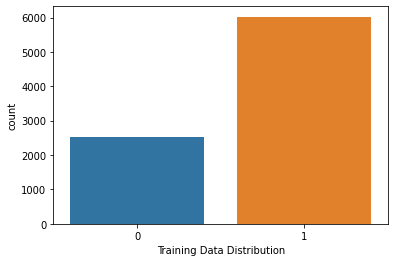

In [25]:
sns.countplot(df_train['label'].values)
plt.xlabel("Training Data Distribution")

Text(0.5, 0, 'Testing Data Distribution')

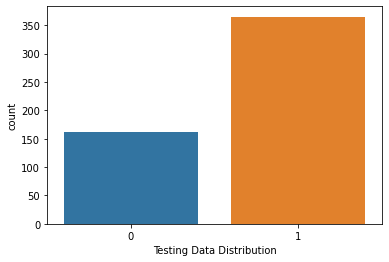

In [26]:
sns.countplot(df_valid['label'].values)
plt.xlabel("Testing Data Distribution")

#### Choosing maximum sequence length

In [27]:
token_lens = []
for txt in df_train.sentence:
  tokens = txt.split()
  token_lens.append(len(tokens))

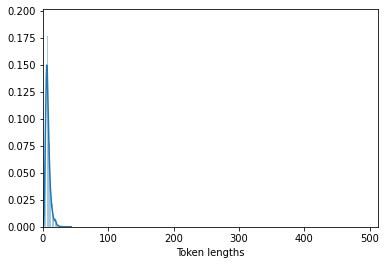

In [28]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token lengths');

### Configurations

In [29]:
OUTPUT_DIM = 1

MAX_LEN = 100

TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8

EPOCHS = 3

MODEL_NAME = "bert-base-uncased"
MODEL_PATH = "model.bin"

TOKENIZER = transformers.BertTokenizer.from_pretrained(MODEL_NAME)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### CoLA Dataset

In [41]:
class CoLADataset:
    def __init__(self, sentences, labels):
        
        self.sentences = sentences
        self.labels = labels

        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        sentence = self.sentences[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt',
        )

        return {
            "ids": encoding["input_ids"].flatten(),
            "mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(label, dtype=torch.float)
        }

In [42]:
train_dataset = CoLADataset(
    sentences=df_train.sentence.values,
    labels=df_train.label.values
)

valid_dataset = CoLADataset(
    sentences=df_valid.sentence.values,
    labels=df_valid.label.values
)

### DataLoaders

In [43]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    TRAIN_BATCH_SIZE,
    shuffle=True
)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    VALID_BATCH_SIZE
)

In [45]:
sample = next(iter(train_data_loader))
sample["ids"].shape, sample["mask"].shape, sample["targets"].shape

(torch.Size([8, 100]), torch.Size([8, 100]), torch.Size([8]))

### BERT Model

In [48]:
class BERTModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.bert = transformers.BertModel.from_pretrained(MODEL_NAME)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, OUTPUT_DIM)
    
    def forward(self, ids, mask):
        _, o2 = self.bert(ids, attention_mask=mask)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

In [49]:
model = BERTModel()
model.to(device)

BERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

### Optimizer

In [50]:
# create parameters we want to optimize
# we generally dont use any decay for bias and weight layers

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay) 
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0
    }
]

In [51]:
num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
num_train_steps

3206

In [54]:
optimizer = AdamW(optimizer_parameters, lr=3e-5)

### Scheduler

In [55]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

### Loss Criterion

In [56]:
criterion = nn.BCEWithLogitsLoss().to(device)

### Training Method

In [63]:
def train_fn(data_loader, model, optimizer, criterion, device, scheduler):
    model.train()
    epoch_loss = 0

    for batch in data_loader:
        ids = batch['ids'].to(device)
        mask = batch["mask"].to(device)
        targets = batch["targets"].to(device)

        optimizer.zero_grad()

        outputs = model(
            ids=ids,
            mask=mask
        )

        loss = criterion(outputs, targets.view(-1, 1))
        
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return epoch_loss / len(data_loader)

### Evaluation Method

In [75]:
def eval_fn(data_loader, model, criterion, device):
    model.eval()

    fin_outputs = []
    fin_targets = []
    epoch_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            ids = batch["ids"].to(device)
            mask = batch["mask"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(
                ids=ids,
                mask=mask
            )

            loss = criterion(outputs, targets.view(-1, 1))
            epoch_loss += loss.item()

            targets = targets.cpu().detach()
            fin_targets.extend(targets.numpy().tolist())

            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs.numpy().tolist())
    outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, outputs)
    mat_cor = metrics.matthews_corrcoef(fin_targets, outputs)
    return epoch_loss / len(data_loader), accuracy, mat_cor

In [76]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training

In [78]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = train_fn(train_data_loader, model, optimizer, criterion, device, scheduler)
    val_loss, val_acc, val_mat_cor = eval_fn(valid_data_loader, model, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), MODEL_PATH)
    
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\t Train Loss: {train_loss:.3f}")
    print(f"\t Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc * 100:.2f} | Matthews Cor: {val_mat_cor:.3f}")

Epoch: 01 | Epoch Time: 5m 43s
	 Train Loss: 0.078
	 Valid Loss: 0.471 | Valid Acc: 85.20 | Matthews Cor: 0.641
Epoch: 02 | Epoch Time: 5m 43s
	 Train Loss: 0.080
	 Valid Loss: 0.471 | Valid Acc: 85.20 | Matthews Cor: 0.641
Epoch: 03 | Epoch Time: 5m 43s
	 Train Loss: 0.079
	 Valid Loss: 0.471 | Valid Acc: 85.20 | Matthews Cor: 0.641


In [84]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

### Inference

In [95]:
def inference(sentence, model, device):
    encoded = TOKENIZER.encode_plus(
        sentence,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt',
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    prediction = torch.round(torch.sigmoid(output))
    print(f'Sentence: {sentence}')
    print(f'Grammatically Correct: {prediction.item()}')

In [96]:
sentence = "I like coding"
inference(sentence, model, device)

Sentence: I like coding
Grammatically Correct: 1.0


In [98]:
sentence = "I myself talking to"
inference(sentence, model, device)

Sentence: I myself talking to
Grammatically Correct: 0.0


In [99]:
sentence = "I am talking to myself"
inference(sentence, model, device)

Sentence: I am talking to myself
Grammatically Correct: 1.0
